# Continuous Distributions

resources:

- [Difference between random draws from scipy.stats…rvs and numpy.random](https://stackoverflow.com/questions/4001577/difference-between-random-draws-from-scipy-stats-rvs-and-numpy-random)
- [Normal distributions (and generally, continuous distributions in SciPy)](http://www.cse.chalmers.se/~richajo/dit862/L4/Lecture%204%20(normal%20distribution).html)

## Normal Distribution

### Normal probability curve

From the book:

"One of the most popular races in the United States is marathon, a grueling 26-mile run. Most people are familiar with the Boston Marathon that is held in Boston, Massachusetts every April. But other cities in the U.S. hold yearly marathons. Here we look at data collected from Grandma’s Marathon that is held in Duluth, Minnesota every June.

In the year 2003, there were 2515 women who completed Grandma’s Marathon. The completion times in minutes for all of these women can be downloaded from the marathon’s website. A histogram of these times, measured in minutes, is shown in Figure 5.17."

In the book I could not find any reference about how to collect the data and so I tried to search on the internet how to retrieve it. After a while, I was able to download a pdf file containing "Grandma's Marathon - Grandma's Marathon - results" (apparently from OnlineRaceResults.com web site). They don't look from 2003 but I was happy enough to have a starting point to show some interesting results about Normal probability curve using real data. Moreover, it was an interesting exercise in Python about retrieving data, cleaning and plotting. In the following I will show the methodology I used for getting the data.

### Goal

The goal is to show that marathon results follow a normal distribution and so the main measure I am interested in is the arrival time. The document containing the data is a `pdf` file, not the ideal source, but luckly Python has a good library ([tabula](https://pypi.org/project/tabula-py/)) for importing data in this format into data frame.

In [1]:
import tabula
import pandas as pd

a1 = tabula.read_pdf('./data/grandmasmarathon.pdf', stream = True, pages = 'all')

Let's see now what I was able to load into da data frame

In [2]:
a1.head()

,nameage sex location,split_1,split_2,split_3,split_4,split_5,pace,time
0,---------------------- --- --- ---------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wesly Ngetich29 MKenya,32:38,1:08:35,1:43:28,32:27,2:15:54,5:12,2:15:55
2,Joseph Kahugu36 MKenya,32:38,1:08:41,1:43:39,33:49,2:17:28,5:15,2:17:29
3,Andrew Letherby33 M,32:39,1:08:42,1:44:54,33:06,2:18:00,5:16,2:18:00
4,James Karanja31 MNairobi,32:38,1:08:40,1:44:04,34:52,2:18:56,5:18,2:18:56


In [3]:
print(a1.shape)
a1.columns

(7119, 8)


Index(['nameage sex location', 'split_1', 'split_2', 'split_3', 'split_4',
       'split_5', 'pace', 'time'],
      dtype='object')

As I was expecting, the formatting is not perfect but since my goal is to get the arrival times it can be enough. 

The next step was to retrieve the information about the sex of the partecipant. In the book, in fact, the results for the female group was considered as it's a good approach to deal with data that are homogeneus. One hypothesis is that female results will follow a normal distribution. And that's true fom male ones as well so, in principle, if we split the results into these two categories we will obtain two normal distributions (and will allow us to see some theoretical results as well).

If we explore the `nameage sex location` column we can notice that the sex of the partecipant follows her/his age. We can use this information to extract the partecipant sex from this column and form a new column called `sex`. The strategy is to find the partecipant age (first number in the `nameage sex location` column) and then take the first character after the age.

In [4]:
a1.drop(a1[a1['time'].str.contains(':') == False].index, inplace = True)
a1.drop(a1[a1['time'].isnull()].index, inplace = True)

In [5]:
import re
import numpy as np

def find_sex(record):
    '''
    record: string
    return: int
    '''
    record = record.replace(" ", "")
    m = re.search(r"\d",record).start()
    return(record[m + 2])



In [6]:
# vectorized version of the function to apply to Series/np.arrays

find_sex_vect = np.vectorize(find_sex)    

# test on the first 10 column entries
find_sex_vect(a1['nameage sex location'].values[:20])

array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M'], dtype='<U1')

In [7]:
a1['sex'] = find_sex_vect(a1['nameage sex location'].values)

Is the strategy working? Let's print the first rows of the data frame

In [8]:
a1.head()

,nameage sex location,split_1,split_2,split_3,split_4,split_5,pace,time,sex
1,Wesly Ngetich29 MKenya,32:38,1:08:35,1:43:28,32:27,2:15:54,5:12,2:15:55,M
2,Joseph Kahugu36 MKenya,32:38,1:08:41,1:43:39,33:49,2:17:28,5:15,2:17:29,M
3,Andrew Letherby33 M,32:39,1:08:42,1:44:54,33:06,2:18:00,5:16,2:18:00,M
4,James Karanja31 MNairobi,32:38,1:08:40,1:44:04,34:52,2:18:56,5:18,2:18:56,M
5,Stephen Muturi31 MKenya,32:45,1:09:06,1:46:44,33:42,2:20:26,5:22,2:20:27,M


Is the `sex` columns contains only capitals `M` or `F`?

In [9]:
a1['sex'].unique()

array(['M', 'F', 'N'], dtype=object)

In [10]:
a1[a1['sex'] == 'N']

,nameage sex location,split_1,split_2,split_3,split_4,split_5,pace,time,sex
689,"Eric Normen0MNew Hope, MN",48:51,1:43:30,2:38:17,49:56,3:28:12,8:00,3:29:43,N


The record shows that in this case the age was not reported correcty (just one digit). Of course, the function for extracting the information about the sex was a "lazy" one, trusting that every record was correct without anticipating any possible mistake. This is my personal strategy: start lazy and optimistic and then check what went wrong and figure out how to solve it. In this case I've been lucky and I get just one record that can be easily amended (of course, as Murphy law would suggest there can be other corrupted records in which I have another one digit age followed by a location starting with `M` or `F` but I think that in this case we can avoid further thinking and go on happily!)  

In [11]:
a1[a1['sex'] == 'N'].index

Int64Index([689], dtype='int64')

In [12]:
a1.loc[a1[a1['sex'] == 'N'].index]

,nameage sex location,split_1,split_2,split_3,split_4,split_5,pace,time,sex
689,"Eric Normen0MNew Hope, MN",48:51,1:43:30,2:38:17,49:56,3:28:12,8:00,3:29:43,N


In [13]:
a1.loc[a1[a1['sex'] == 'N'].index.values[0]]['sex'] = 'M'

In [14]:
a1['sex'].unique()

array(['M', 'F'], dtype=object)

In [15]:
a1.loc[689]

nameage sex location    Eric Normen0MNew Hope, MN
split_1                                     48:51
split_2                                   1:43:30
split_3                                   2:38:17
split_4                                     49:56
split_5                                   3:28:12
pace                                         8:00
time                                      3:29:43
sex                                             M
Name: 689, dtype: object

So far, so good. I now build a dataframe consisting of the `sex` and `times` columns only

In [16]:
df_times_data = a1[['sex', 'time']].reset_index(drop = True) 

In [17]:
df_times_data.head()

,sex,time
0,M,2:15:55
1,M,2:17:29
2,M,2:18:00
3,M,2:18:56
4,M,2:20:27


In [18]:
type(df_times_data['time'][0])

str

As expected, the `time` column contains string. We need to transform in integer representing how many minutes it took for the partecipant to finish the marathon. 

In [19]:
from operator import mul

def convert_h2min(to_convert):
    ''' 
    to_convert: string
    returns int
    '''
    factors = (60, 1, 1/60)

    return(sum(i*j for i, j in zip(map(int, to_convert.split(':')), factors)))
    # return(sum(map(mul, map(int, to_convert.split(':')), factors)))
convert_h2min_vect = np.vectorize(convert_h2min)

In [20]:
df_times_data['minutes'] = convert_h2min_vect(df_times_data['time'])

In [21]:
df_times_data.head()

,sex,time,minutes
0,M,2:15:55,135.916667
1,M,2:17:29,137.483333
2,M,2:18:00,138.000000
3,M,2:18:56,138.933333
4,M,2:20:27,140.450000


In [22]:
# df_times_data.to_pickle('./data/df_times_data.pkl')

How does the histogram of `minutes` look like? 

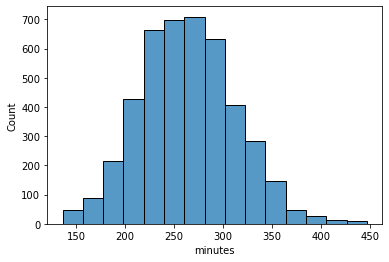

In [23]:
import seaborn as sns

sns.histplot(data=df_times_data[df_times_data['sex'] == 'M'],
            x = 'minutes',
            bins = 15);

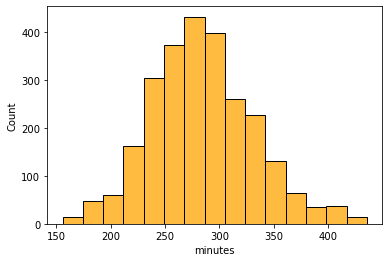

In [24]:
import seaborn as sns

sns.histplot(data=df_times_data[df_times_data['sex'] == 'F'],
            x = 'minutes', 
             color = 'orange',
             bins = 15);

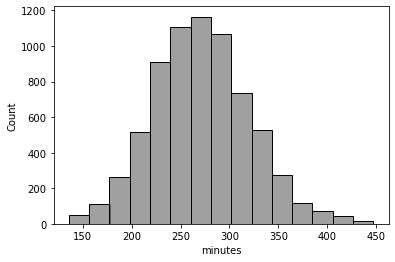

In [25]:
import seaborn as sns

sns.histplot(data=df_times_data,
            x = 'minutes',
             color= 'gray',
             bins = 15);

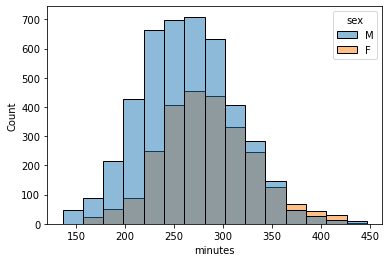

In [26]:
import seaborn as sns

sns.histplot(data=df_times_data,
            x = 'minutes', 
             hue = 'sex',
             bins = 15);

## Adolphe Quetelet Chest dataset

A "lazy" search on the internet to find Adolphe Quetelet was unsuccessful (I was surprised I could not find anything on Kaggle). Luckly there is an easy way to retrieve this data as R programming ACSWR package provides the `chest` dataframe that can be explorted into a `csv` file. Once you export it from R, you can import in Python

In [27]:
df_chest = pd.read_csv('./data/chest.csv').drop('Unnamed: 0',axis= 1).reset_index(drop = True)
df_chest.head()

,Chest,Count
0,33,3
1,34,18
2,35,81
3,36,185
4,37,420


The dataset is counting the occourrences (frequency) of the different chest measurements (in inchs). An easy way to visualize it is using a bar plot:

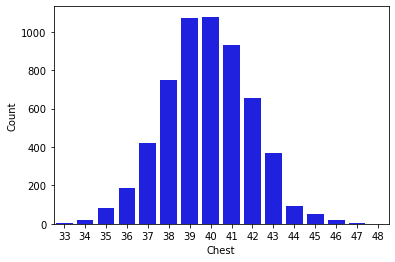

In [28]:
sns.barplot(data=df_chest,
            x='Chest',
            y='Count',
           color='blue');

Just for fun, let's transform the data in a way more suitable for a histogram format, i.e. moving from frequencies to actual measurements.

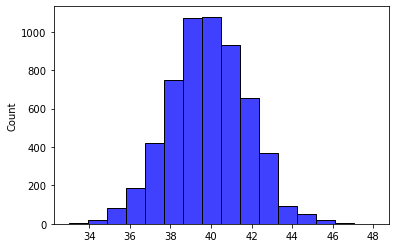

In [29]:
sns.histplot(np.repeat(df_chest.Chest, df_chest.Count).values,
             bins = df_chest.shape[0],
            color='blue');
#np.repeat(df_chest.Chest, df_chest.Count).values;

In [30]:
df_chest.shape[0]

16

## Normal Distribution in Python

While `R` does not any special library to deal with distributions, in Python we have several ways to deal with probabilities. My "lazy" strategy, of course, is to refer to the basics: `numpy` and `scipy.stats` as the share a similar philosophy\vocabulary.  

#### Drawing samples from a Norma Distribution

There are mainly two ways to draw samples from a normal distribution: using `numpy.random.normal` and `scipy.stats.norm.rvs`

In [31]:
mu = 250
sigma = 34

In [32]:
import numpy as np

np.random.seed(1234)
a1 = np.random.normal(loc = mu, scale = sigma, size = 1000)

In [33]:
type(a1)

numpy.ndarray

In [34]:
a1[:5]

array([266.02879557, 209.50682638, 298.71203693, 239.36983553,
       225.49998307])

In [35]:
from scipy.stats import norm

np.random.seed(1234)
a2 = norm.rvs(loc = mu, scale = sigma, size = 1000)

In [36]:
type(a2)

numpy.ndarray

In [37]:
a2[:5]

array([266.02879557, 209.50682638, 298.71203693, 239.36983553,
       225.49998307])

##### Marathon data

Analysing the Grandma’s Marathon we made the assumption that the arrival times of the Female competition is following a normal distribution with mean $\mu$= 284.0 minutes and $\sigma$= 47.0 minutes. We can build the density function using `scipy.stats.norm` function

In [38]:
arrival_times = norm(loc = 284, scale = 47)

If we are interested in the probability that a woman marathon runner completes the race in under 240, we can use the `cdf()` function

In [39]:
arrival_times.cdf(240)

0.1745927785587299

And if we are interested in computing the probability that a marathon runner completes a race between two values, such as $P(230 < X < 280)$ we can calculate the difference of two `cdf()`s

In [40]:
arrival_times.cdf(240) - arrival_times.cdf(230)

0.04930162775894026

### Plotting the normal curve

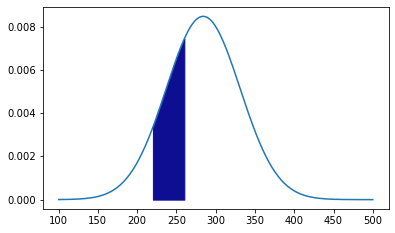

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure();
ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))

interval = np.linspace(100, 500,200)
section = np.linspace(220, 260,40)

ax.fill_between(section,arrival_times.pdf(section), color = '#0e0e92')

ax = sns.lineplot(x=interval,
            y = arrival_times.pdf(interval))

### Quantile function (percent point function, ppf)

From Wikipedia

The **quantile function**, associated with a probability distribution of a random variable, specifies the value of the random variable such that the probability of the variable being less than or equal to that value equals the given probability. It is also called the **percent-point function** or **inverse cumulative distribution function**.

From Little Inference Book

The $\alpha^{th}$ quantile of a distribution with distribution function F is the point $x_{\alpha}$ so that

$$F(x_{\alpha}) = \alpha $$

So the 0.95 quantile of a distribution is the point so that 95% of the mass of the density lies below it. Or, in other words, the point so that the probability of getting a randomly sampled point below it is 0.95. This is analogous to the sample quantiles where the 0.95 sample quantile is the value so that 95% of the data lies below it.

A **percentile** is simply a quantile with $\alpha$ expressed as a percent rather than a proportion. The (population) median is the 50<sup>th</sup> percentile. 

For the normal distributution we have `stats.norm.ppf` that compute its percentile.

In [42]:
norm.ppf(0.8, loc = 0, scale = 1)

0.8416212335729143

<AxesSubplot:>

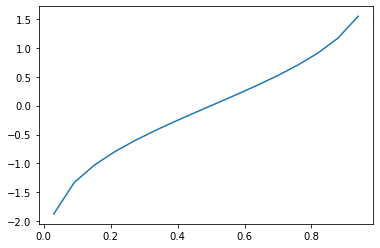

In [43]:
interval = np.linspace(-3,3,100)
sns.lineplot(interval,
            norm.ppf(interval, 0, 1))

<AxesSubplot:>

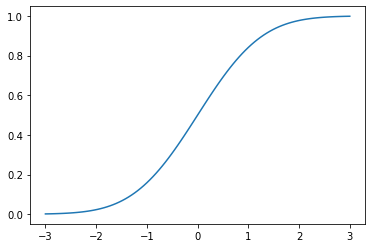

In [44]:
interval = np.linspace(-3,3,100)
sns.lineplot(interval,
            norm.cdf(interval, 0, 1))

## The Central Limit Theorem works for any population

To show how the Central Limit Theorem works, it's helpful to consider a custom probability distribution from which extracting random samples. I am going to use the density curve of the population of distance described in the book. The information i have is that this distribution models the fact that "the large number of students whose homes are in the ranges 0 to 40 miles and 70 to 130 miles" and so we can chose two normal distribution with means 20 and 100 and standard deviations 6 and 14 respectively.

If we want to build a pdf summing the two normal pdfs, we have to divide the sum by 2 as the integral of the resulting function within the domain must be 1

$$
\begin{align}
X &\sim \mathcal{N}(\mu_{1},\,\sigma_{1}^{2}) + \mathcal{N}(\mu_{2},\,\sigma_{2}^{2}) \\
&\sim \mathcal{N}(20,\,(6)^{2}) + \mathcal{N}(100,\,(14)^{2})
\end{align}
$$

In [45]:
from scipy.stats import norm

norm_1 = norm(loc = 20, scale = 6)

In [46]:
from scipy.stats import norm

norm_2 = norm(loc = 100, scale = 14)

In [47]:
norm_1.cdf(-150)

6.7157348018746805e-177

In [48]:
import numpy as np

interval = np.linspace(0,150,300)

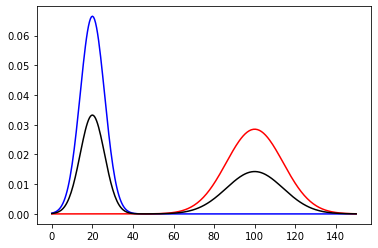

In [49]:
import seaborn as sns

sns.lineplot(x = interval,
             y = norm_1.pdf(interval),
            color = 'blue');

sns.lineplot(x = interval,
             y = norm_2.pdf(interval),
            color = 'red');

sns.lineplot(x = interval,
            y = (norm_1.pdf(interval) + norm_2.pdf(interval))/2,
            color = 'black');

Let's now build the combined density function as

In [50]:
from scipy import stats

class comb_distribution(stats.rv_continuous):
    norm_1 = norm(loc = 25, scale = 6)
    norm_2 = norm(loc = 100, scale = 14)
    
    def _pdf(self, x):
        return ((norm_1.pdf(x) + norm_2.pdf(x))/2)

distribution = comb_distribution(a = 0, b = 150)

If I draw 100 samples from the distribution

In [51]:
# sample_1000 = np.array([distribution.rvs() for _ in np.arange(1000)])
# np.save('./data/sample_1000', sample_1000)

In [57]:
sample_1000 = np.load('./data/sample_1000.npy')

In [58]:
sample_1000.mean()

59.98274299127199

In [59]:
sample_1000.std()

41.62991373001282

> to review to match the theoretical mean and standard deviation

This distribution has a mean $\mu = 60$ and standard deviation $\sigma = 41.2$

### Central Limit Theorem

 **Central Limit Theorem**: if one takes sample means from any population with mean $\mu$ and standard deviation $\sigma$, then the sampling distribution of the means (for large enough sample size) will be approximately normally distributed with mean and standard deviation

$$E(\bar{X}) = \mu, SD(\bar{X}) = \frac{\sigma}{\sqrt{n}}$$

In our example, $\mu = 60$ and $\sigma = 41.2$

##### samples $n = 1$ 

Considering taking the mean of $n = 1$ samples for $k = 200$ (k is fixed for all our choices of the different n samples) experiment and calculate mean and standard deviation of means. Note that of course, the mean of one measurement its the measurement itself.

In [60]:
def draw_sample(n_samples):
    return(np.array([np.int(distribution.rvs()) for _ in np.arange(n_samples)]))

In [92]:
df_means = pd.read_pickle('./data/df_means.pkl')

In [96]:
# np.random.seed(1234)
# k = 200
# n_samples = 1

# X_1 = np.array([draw_sample(n_samples).mean() for _ in np.arange(k)])
X_1 = df_means['X_1']

In [97]:
X_1.mean()

64.25

In [98]:
X_1.std()

41.19908156267613

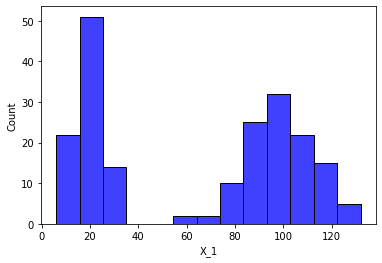

In [99]:
sns.histplot(X_1,
             bins=13,
            color = 'blue');

##### samples $n = 2$

In [100]:
# np.random.seed(2341)
# n_samples = 2

# X_2 = np.array([draw_sample(n_samples).mean() for _ in np.arange(k)])

In [101]:
X_2 = df_means['X_2']

In [102]:
X_2.mean()

59.95

In [103]:
X_2.std()

30.841302333854866

In [104]:
41/np.sqrt(2)

28.991378028648448

##### samples $n = 5$

In [105]:
# np.random.seed(3412)
# n_samples = 5

# X_5 = np.array([draw_sample(n_samples).mean() for _ in np.arange(k)])

In [106]:
X_5 = df_means['X_5']

In [107]:
X_5.mean()

59.35000000000004

In [108]:
X_5.std()

17.666272553361345

In [109]:
41/np.sqrt(5)

18.335757415498275

##### samples $n = 20$

In [110]:
# np.random.seed(4123)
# n_samples = 20

# X_20 = np.array([draw_sample(n_samples).mean() for _ in np.arange(k)])

In [111]:
X_20 = df_means['X_20']

In [112]:
X_20.mean()

59.47225000000007

In [113]:
X_20.std()

9.470737393221121

In [114]:
41/np.sqrt(20)

9.167878707749137

In [86]:
# import pandas as pd

# df_means = pd.DataFrame({'Trial':np.arange(200),
#                         'X_1':X_1,
#                         'X_2':X_2,
#                         'X_5':X_5,
#                         'X_20':X_20})

In [115]:
# df_means.to_pickle('./data/df_means.pkl')

In [116]:
df_means = pd.read_pickle('./data/df_means.pkl')

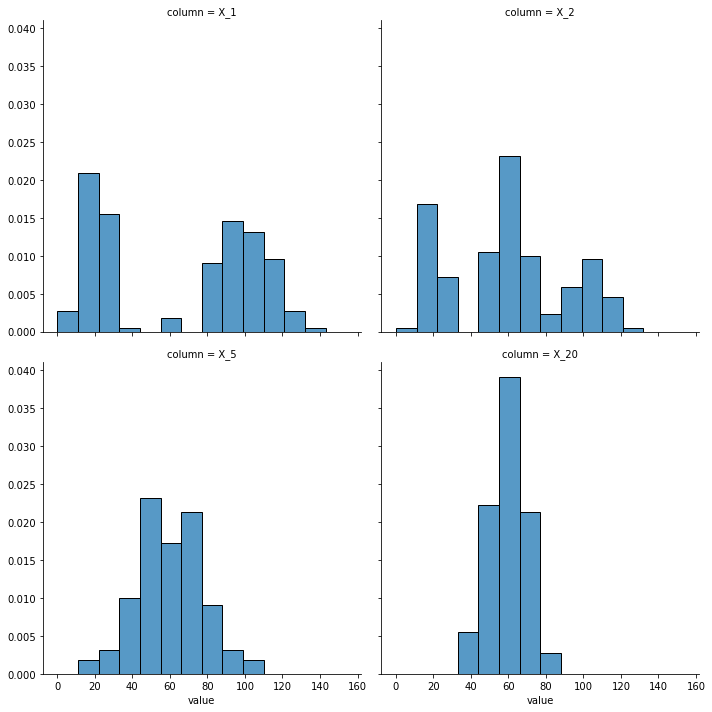

In [117]:
import matplotlib.pyplot as plt

cols = ['X_1','X_2','X_5','X_20']

df_melted = df_means[cols].melt(var_name='column')

g = sns.FacetGrid(df_melted, 
                  col='column', 
                  col_wrap=2, 
                  height=5);
g.map(sns.histplot, 
      'value', 
      binwidth = 11, 
      binrange = [0,150],
      stat = 'density', ax = ax);